In [1]:
import torch
import math
import random
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

# **Task**

We train a baseline language model on the Tiny Shakespeare corpus. In particular, we will use character-level tokenization, and predict the next character given the previous $k$ characters (conditional probability over characteers). To achieve this we will train the model to maximize the log-likelihood of the data. 

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{k} \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta) = \max_{\theta} \sum_{i=1}^{N} \sum_{j=1}^{k} \log \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta)
$$

where $\mathbf{x}_i$ is the $i$-th sequence in the dataset created from the corpus, $N$ is the number of sequences in the dataset and $\theta$ are the parameters of the model.

# **Dataset**

In [2]:
# load data
corpus = open('tiny_shakespeare.txt', 'r').read()
print(corpus[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


No. characteres: 1115393. Unique set: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


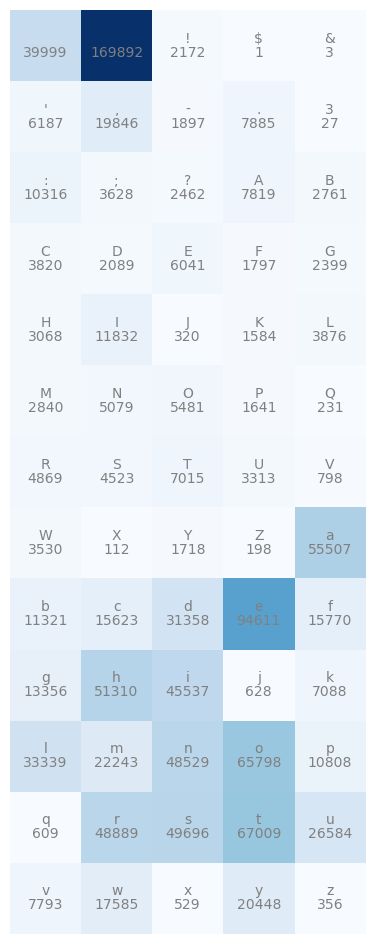

In [3]:
# map each character to an integer and vice versa
chars = sorted(set(corpus))
idx2char = dict(enumerate(chars))
char2idx = {v: k for (k, v) in idx2char.items()}
print(f'No. characteres: {len(corpus)}. Unique set: {chars}')

# Count number of occurrences of each character
char_counts = torch.zeros(len(chars), dtype = torch.int32)
for c in corpus:
    char_counts[char2idx[c]] += 1

# Display character counts
plt.figure(figsize=(12, 12))
plt.imshow(char_counts.view(-1, 5), cmap='Blues')
plt.axis('off')
for i in range(len(chars)):
    plt.text(i % 5, i//5, idx2char[i], ha='center', va='bottom', color='gray')
    plt.text(i % 5, i//5, char_counts[i].item(), ha='center', va='top', color='gray')

In [4]:
# Form dataset from corpus
block_size = 20 # context size for next character prediction

X, Y = [], []
for i in range(len(corpus[:1000])):
    # skip first block_size characters
    # Q: During inference, how do we start if the model always only trained
    #    sequences (context) that had text in it? 
    if i < block_size: 
        continue
    X.append([char2idx[j] for j in  corpus[(i-block_size):i]])
    Y.append(char2idx[corpus[i]])
    
for i in range(5):
    # check the data looks as expected
    print(f'{i}. {"".join([idx2char[j] for j in X[i]])} --> {idx2char[Y[i]]}')
    print(f'{i}. {X[i]} --> {Y[i]}')

0. First Citizen:
Befor --> e
0. [18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56] --> 43
1. irst Citizen:
Before -->  
1. [47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43] --> 1
2. rst Citizen:
Before  --> w
2. [56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1] --> 61
3. st Citizen:
Before w --> e
3. [57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61] --> 43
4. t Citizen:
Before we -->  
4. [58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43] --> 1


In [5]:
random.seed(42)
torch.manual_seed(42)

# shuffle data
idx_perm = torch.randperm(len(X))
X = torch.tensor(X)[idx_perm]
Y = torch.tensor(Y)[idx_perm]

# split data into train, validation and test sets
n1 = int(len(X)*0.8)
n2 = int(len(X)*0.9)
X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2:], Y[n2:]

print(f'X_train: {X_train.shape} | Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape} | Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape} | Y_test: {Y_test.shape}')

X_train: torch.Size([784, 20]) | Y_train: torch.Size([784])
X_val: torch.Size([98, 20]) | Y_val: torch.Size([98])
X_test: torch.Size([98, 20]) | Y_test: torch.Size([98])


# **Transformer model**

In [6]:
# input and output token embedding
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)
        
    def forward(self, x):
        return self.embed(x) * math.sqrt(self.d_model)

# positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return x
    
# multi-head attention layer 
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        # Instead of a set of projection matrices (Wq_i, Wk_i, Wv_i) for each head i,
        # we use one big projection matrix and split the result into the different heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

        # attention holds no state itself, it is just a function
    def attention(self, Q, K, V, d_k):
        scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
        scores = F.softmax(scores, dim=-1)
        return scores @ V
        
    def forward(self, Q, K, V):
        # Q, K, V: (batch_size, seq_len, d_model)
        batch_size = Q.shape[0]
        Q = self.Wq(Q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        K = self.Wk(K).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        V = self.Wv(V).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        scores = self.attention(Q, K, V, self.d_k)
        scores = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.Wo(scores)

# transformer encoder layer
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, heads=8, d_ff=2048):
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.d_ff = d_ff
        self.attention = MultiHeadAttention(d_model, heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        
    def forward(self, x):
        x = self.layer_norm1(x + self.attention(x, x, x))
        x = self.layer_norm2(x + self.feed_forward(x))
        return x
    
# transformer model
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, heads, d_ff, num_layers):
        super().__init__()
        self.d_model = d_model
        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layers = nn.ModuleList([TransformerEncoder(d_model, heads, d_ff) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        return self.fc(x)

In [10]:
# model
torch.manual_seed(42)
model = Transformer(len(chars), 512, 8, 2048, 1)
print(f'Number of model parameters: {sum([p.numel() for p in model.parameters()])}')

# Training loop
max_epochs = 100
batch_size = 32
lr = 0.1

# tracking
losses = []

for i in range(max_epochs):
    model.train() # set model to train mode
    idx_perm = torch.randperm(X_train.shape[0])
    X_train_batches = torch.split(X_train[idx_perm], batch_size, 0)
    Y_train_batches = torch.split(Y_train[idx_perm], batch_size, 0)
    batch_losses = []
    for X_batch, Y_batch in zip(X_train_batches, Y_train_batches):
        # forward
        logits = model(X_batch)
        # pick logits of last character to predict next (not sure this is correct)
        loss = F.cross_entropy(logits[:, -1], Y_batch) # softmax, negative log, sum

        # backward
        model.zero_grad()
        loss.backward()

        # update step
        for p in model.parameters():
            p.data -= lr * p.grad
        
        # tracking
        with torch.no_grad():
            losses.append(loss.item())
            batch_losses.append(loss.item())

    print(f'Epoch {i}/{max_epochs} - Loss: {sum(batch_losses) / len(batch_losses)}')

Number of model parameters: 3219009
Epoch 0/100 - Loss: 3.5571353530883787
Epoch 1/100 - Loss: 3.0355227851867674
Epoch 2/100 - Loss: 2.9467371463775636
Epoch 3/100 - Loss: 2.793426275253296
Epoch 4/100 - Loss: 2.6439006423950193
Epoch 5/100 - Loss: 2.54692617893219
Epoch 6/100 - Loss: 2.568589849472046
Epoch 7/100 - Loss: 2.56285843372345
Epoch 8/100 - Loss: 2.6191824531555175
Epoch 9/100 - Loss: 2.53692795753479
Epoch 10/100 - Loss: 2.471335153579712
Epoch 11/100 - Loss: 2.3526071739196777
Epoch 12/100 - Loss: 2.3184242486953734
Epoch 13/100 - Loss: 2.261159563064575
Epoch 14/100 - Loss: 2.224568042755127
Epoch 15/100 - Loss: 2.1913883018493654
Epoch 16/100 - Loss: 2.1095119667053224
Epoch 17/100 - Loss: 2.080489149093628
Epoch 18/100 - Loss: 2.013781452178955
Epoch 19/100 - Loss: 2.1214849042892454
Epoch 20/100 - Loss: 2.1582638931274416
Epoch 21/100 - Loss: 2.030302710533142
Epoch 22/100 - Loss: 2.0169106006622313
Epoch 23/100 - Loss: 2.004024262428284
Epoch 24/100 - Loss: 1.879729

KeyboardInterrupt: 

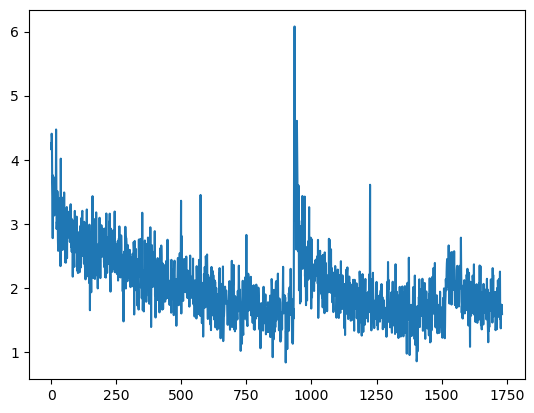

In [11]:
plt.plot(losses)